# HICO-DET

[HICO & HICO-DET Benchmarks for Recognizing Human-Object Interactions in Images](http://www-personal.umich.edu/~ywchao/hico/)

In [1]:
%matplotlib inline
import io

from collections import defaultdict

import cv2
import torch
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from itertools import zip_longest
from IPython.display import display, Markdown, HTML
from torchvision.ops.boxes import box_iou, nms, batched_nms

hico_dir = Path('../../data/hico_20160224_det/raw')

## Data loading

### Objects, actions, interactions

In [2]:
f = scipy.io.loadmat(hico_dir.joinpath('anno_bbox.mat').as_posix())

In [3]:
actions = []
interactions = []

for interaction in f['list_action'].squeeze():
    interactions.append({
        'action': interaction['vname'].item(),
        'object': interaction['nname'].item()
    })
    actions.append({
        'action': interaction['vname'].item(),
        'ing': interaction['vname_ing'].item(),
        'add_def': interaction['add_def'].tolist(),
        **({
            'id': interaction['synset']['id'].item().item(),
            'wid': interaction['synset']['wid'].item().item(),
            'name': interaction['synset']['name'].item().item(),
            'count': interaction['synset']['count'].item().item(),
            'synonymes': interaction['synset']['syn'].item().item(), 
            'definition': interaction['synset']['def'].item().item(),
            'examples': interaction['synset']['ex'].item().tolist()
        } if interaction['vname'].item() != 'no_interaction' else {})
    })

del interaction

actions = pd.DataFrame(actions).drop_duplicates('action')
interactions = pd.DataFrame(interactions).rename_axis(index='id')

Action types (verbs) and their descriptions.

In [4]:
actions.set_index('action')

,ing,add_def,id,wid,name,count,synonymes,definition,examples
action,,,,,,,,,
board,boarding,[],1.0,v02018049,board.v.01,6,board get_on,"get on board of (trains, buses, ships, aircraf...",[]
direct,directing,[],5.0,v01999798,lead.v.01,131,lead take direct conduct guide,take somebody somewhere,[We lead him to our chief]
exit,exiting,[],1.0,v02015598,exit.v.01,72,exit go_out get_out leave,move out of or depart from,[leave the room]
fly,flying,[],3.0,v01941093,fly.v.03,6,fly aviate pilot,operate an airplane,[The pilot flew to Cuba]
inspect,inspecting,[],1.0,v02165543,inspect.v.01,13,inspect,look over carefully,[Please inspect your father's will carefully]
...,...,...,...,...,...,...,...,...,...
flush,flushing,[],5.0,v00455529,flush.v.05,0,flush scour purge,"rinse, clean, or empty with a liquid",[flush the wound with antibiotics]
brush_with,brushing_with,[],1.0,v01243809,brush.v.01,11,brush,"rub with a brush, or as if with a brush",[Johnson brushed the hairs from his jacket]
install,installing,[],1.0,v01569566,install.v.01,37,install instal put_in set_up,set up for use,[install the washer and dryer]


Interaction types (verb + object), subject is always "person".

In [5]:
interactions

,action,object
id,,
0,board,airplane
1,direct,airplane
2,exit,airplane
3,fly,airplane
4,inspect,airplane
...,...,...
595,feed,zebra
596,hold,zebra
597,pet,zebra


Objects

In [6]:
l = [f'{class_idx:2} {class_name:15}' for class_idx, class_name in interactions['object'].drop_duplicates().reset_index(drop=True).iteritems()]

for row in zip_longest(*np.array_split(l, 4), fillvalue=''):
    print(*row)

 0 airplane        20 apple           40 frisbee         60 skateboard     
 1 bicycle         21 backpack        41 giraffe         61 skis           
 2 bird            22 banana          42 hair_drier      62 snowboard      
 3 boat            23 baseball_bat    43 handbag         63 spoon          
 4 bottle          24 baseball_glove  44 hot_dog         64 sports_ball    
 5 bus             25 bear            45 keyboard        65 stop_sign      
 6 car             26 bed             46 kite            66 suitcase       
 7 cat             27 bench           47 knife           67 surfboard      
 8 chair           28 book            48 laptop          68 teddy_bear     
 9 couch           29 bowl            49 microwave       69 tennis_racket  
10 cow             30 broccoli        50 mouse           70 tie            
11 dining_table    31 cake            51 orange          71 toaster        
12 dog             32 carrot          52 oven            72 toilet         
13 horse    

Actions

In [7]:
l = [f'{class_idx:2} {class_name:15}' for class_idx, class_name in interactions['action'].drop_duplicates().reset_index(drop=True).iteritems()]

for row in zip_longest(*np.array_split(l, 4), fillvalue=''):
    print(*row)

 0 board           30 drink_with      59 cut             88 catch          
 1 direct          31 lick            60 eat             89 spin           
 2 exit            32 open            61 peel            90 operate        
 3 fly             33 pour            62 pick            91 type_on        
 4 inspect         34 wave            63 smell           92 assemble       
 5 load            35 hose            64 wear            93 pull           
 6 ride            36 dry             65 break           94 cut_with       
 7 sit_on          37 hug             66 sign            95 squeeze        
 8 wash            38 kiss            67 swing           96 pay            
 9 no_interaction  39 scratch         68 throw           97 slide          
10 carry           40 lie_on          69 wield           98 move           
11 hold            41 herd            70 hunt            99 point          
12 jump            42 lasso           71 read            100 flip           
13 hop_on  

### Image shapes

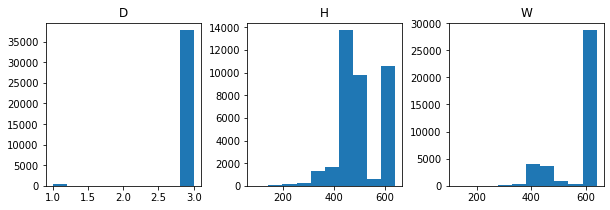

In [8]:
img_info = []
for img in f['bbox_train'].squeeze():
    img_info.append({
        'filename': img['filename'].item(),
        'D': img['size']['depth'].item().item(),
        'H': img['size']['height'].item().item(),
        'W': img['size']['width'].item().item()
    })
del img
img_info = pd.DataFrame(img_info)
img_info.drop(columns='filename').hist(layout=(1,3), figsize=(10, 3), grid=False);

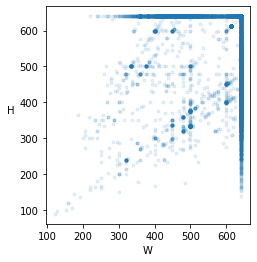

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(img_info.W, img_info.H, marker='.', alpha=.1)
ax.set_xlabel('W')
ax.set_ylabel('H   ', rotation=0)
ax.set_aspect('equal');

### Samples

Each sample has this structure (from the attached documentation):
```
filename: file names
size:     image width, hieght, depth
hoi:      HOI annotations
    id:          action index of list_action
    bboxhuman:   human bounding boxes
    bboxobject:  object bounding boxes
    connection:  instances of HOI (human-object pairs); each row is
                 one instance, represented by a pair of human bbox
                 index and object bbox index
    invis:       1: HOI invisible; bboxhuman/bboxobject/connection
                    will be empty
                 0: HOI visible; bboxhuman/bboxobject/connection
                    will not be empty
```

In [10]:
samples = []
hoi_counts = defaultdict(lambda: 0)

for img in f['bbox_train'].squeeze():
    filename = img['filename'].item()
    
    # All interaction types, e.g. (person, load, truck)
    for interaction in img['hoi'].squeeze(0):
        interaction_id = interaction['id'].item() - 1
        
        # Invisible interaction, no humans or objects visible
        if interaction['invis'].item() == 1:
            samples.append({
                'filename': filename,
                'interaction_id': interaction_id,
                'instance_id': -1,
                'bb_human': None,
                'bb_object': None,
                'visible': False,
            })
            continue
        
        # All humans involved in one or more instances of this interaction
        humans = [
            (human['x1'].item(), human['y1'].item(), human['x2'].item(), human['y2'].item())
            for human in interaction['bboxhuman'].squeeze(0)
        ]
            
        # All objects involved in one or more instances of this interaction
        objects = [
            (object['x1'].item(), object['y1'].item(), object['x2'].item(), object['y2'].item())
            for object in interaction['bboxobject'].squeeze(0)
        ]
        
        # All instances of this interaction type, e.g.
        # (person1, loads, truck1)
        # (person2, loads, truck1)
        # (person3, loads, truck2)
        # (person4, loads, truck2)
        action_instances = interaction['connection'].shape[0]
        for instance_id, instance in enumerate(interaction['connection']):          
            samples.append({
                'filename': filename,
                'interaction_id': interaction_id,
                'instance_id': instance_id,
                'bb_human': humans[instance[0] - 1],
                'bb_object': objects[instance[1] - 1],
                'visible': True,
            })
            hoi_counts[tuple(interactions.loc[interaction_id])] += 1

samples = pd.DataFrame(samples)

In [15]:
from xib.datasets.hico_det.metadata import OBJECTS, PREDICATES, HOI

In [17]:
{hoi: hoi_counts[(PREDICATES.get_str(hoi[0]), OBJECTS.get_str(hoi[1]))] for hoi in HOI}

{(4, 4): 176,
 (17, 4): 98,
 (25, 4): 56,
 (30, 4): 181,
 (41, 4): 198,
 (52, 4): 75,
 (76, 4): 284,
 (87, 4): 319,
 (111, 4): 4,
 (57, 4): 274,
 (8, 1): 23,
 (36, 1): 1995,
 (41, 1): 138,
 (43, 1): 121,
 (37, 1): 27,
 (62, 1): 17,
 (71, 1): 116,
 (75, 1): 87,
 (76, 1): 2206,
 (87, 1): 1904,
 (98, 1): 2250,
 (110, 1): 180,
 (111, 1): 2,
 (57, 1): 396,
 (10, 14): 45,
 (26, 14): 257,
 (36, 14): 127,
 (65, 14): 5,
 (74, 14): 16,
 (112, 14): 439,
 (57, 14): 85,
 (4, 8): 103,
 (21, 8): 214,
 (25, 8): 39,
 (41, 8): 117,
 (43, 8): 11,
 (47, 8): 176,
 (75, 8): 63,
 (76, 8): 4051,
 (77, 8): 757,
 (79, 8): 380,
 (87, 8): 2385,
 (93, 8): 1626,
 (105, 8): 44,
 (111, 8): 2,
 (57, 8): 401,
 (8, 39): 154,
 (20, 39): 160,
 (36, 39): 540,
 (41, 39): 51,
 (48, 39): 7,
 (58, 39): 17,
 (69, 39): 23,
 (57, 39): 527,
 (4, 5): 247,
 (17, 5): 6,
 (21, 5): 463,
 (25, 5): 29,
 (41, 5): 27,
 (52, 5): 71,
 (76, 5): 1519,
 (87, 5): 992,
 (111, 5): 6,
 (113, 5): 1,
 (57, 5): 226,
 (4, 2): 27,
 (17, 2): 1,
 (21, 2):

In [56]:
for k in range(5, 21):
    print(f'{k:>2}             ', len({hoi: count for hoi, count in hoi_counts.items() if count < k and hoi[0]!='no_interaction'}))

 5              94
 6              108
 7              117
 8              123
 9              126
10              132
11              138
12              146
13              151
14              156
15              160
16              166
17              170
18              175
19              178
20              179


In [60]:
for k in range(5, 21):
    print(f'{k:>2}             ', len({hoi: count for hoi, count in hoi_counts.items() if count < k}))

 5              100
 6              114
 7              123
 8              129
 9              132
10              138
11              144
12              154
13              159
14              164
15              168
16              174
17              178
18              183
19              187
20              190


Here are some examples of what happens when an image contains more interaction types, and when an interaction type has more instances, 

In [11]:
examples = (
    'HICO_train2015_00000001.jpg',
    'HICO_train2015_00000009.jpg',
    'HICO_train2015_00000014.jpg',
    'HICO_train2015_00000059.jpg',
    'HICO_train2015_00000061.jpg',
    'HICO_train2015_00002389.jpg',
)

display(
    pd.merge(
        left=samples,
        right=pd.Series((f'[{i:03}] {a} {o}' for i, a, o 
                         in interactions.itertuples()), name='interaction'),
        left_on='interaction_id',
        right_index=True
    )
    .drop(columns='interaction_id')
    .set_index(['filename', 'interaction', 'instance_id'])
    .sort_index()
    .loc[pd.IndexSlice[examples, :, :], :]
    .style
    .format({True: 'v', False: 'x'}.get, subset='visible')
    .highlight_max(axis=0, color='""; color: green; font-weight: bold;', subset='visible')
    .highlight_min(axis=0, color='""; color: red;', subset='visible')
)

del examples

## Statistics

In [12]:
df = pd.merge(
    left=samples,
    right=interactions,
    left_on='interaction_id',
    right_index=True
).sort_values('filename')
df.head()

,filename,interaction_id,instance_id,bb_human,bb_object,visible,action,object
0,HICO_train2015_00000001.jpg,152,0,"(208, 33, 427, 300)","(59, 98, 572, 405)",True,race,motorcycle
3,HICO_train2015_00000001.jpg,155,0,"(209, 26, 444, 317)","(59, 99, 579, 395)",True,straddle,motorcycle
2,HICO_train2015_00000001.jpg,154,0,"(206, 33, 427, 306)","(61, 100, 571, 401)",True,sit_on,motorcycle
1,HICO_train2015_00000001.jpg,153,0,"(213, 20, 438, 357)","(77, 115, 583, 396)",True,ride,motorcycle
4,HICO_train2015_00000002.jpg,223,0,"(262, 1, 638, 138)","(162, 131, 258, 165)",True,no_interaction,banana


#### Instances of objects, humans and interactions

Number of human and object boxes per image:
- hard to say because for every interaction type the boxes are redefined, 
  even if a box around the objects involved already exists (see `HICO_train2015_00000001.jpg` above).

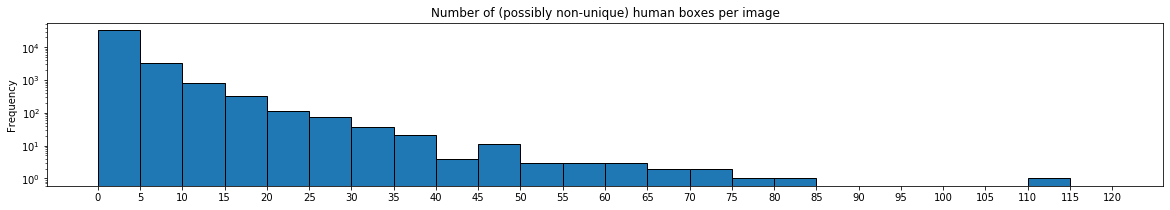

In [13]:
bins = np.arange(0, df.groupby('filename').agg({'bb_human': 'nunique'}).bb_human.max() + 10, 5)
ax = df.groupby('filename').agg({'bb_human': 'nunique'}).bb_human.plot.hist(logy=True, figsize=(20, 3), edgecolor='k', bins=bins, align='mid')
ax.set_title('Number of (possibly non-unique) human boxes per image')
ax.set_xticks(bins);

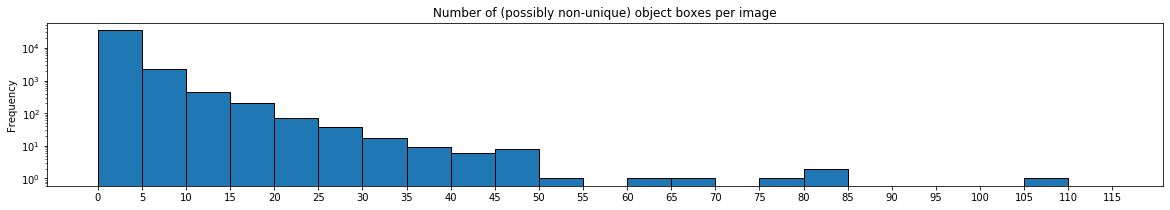

In [14]:
bins = np.arange(0, df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.max() + 10, 5)
ax = df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.plot.hist(logy=True, figsize=(20, 3), edgecolor='k', bins=bins, align='mid')
ax.set_title('Number of (possibly non-unique) object boxes per image')
ax.set_xticks(bins);

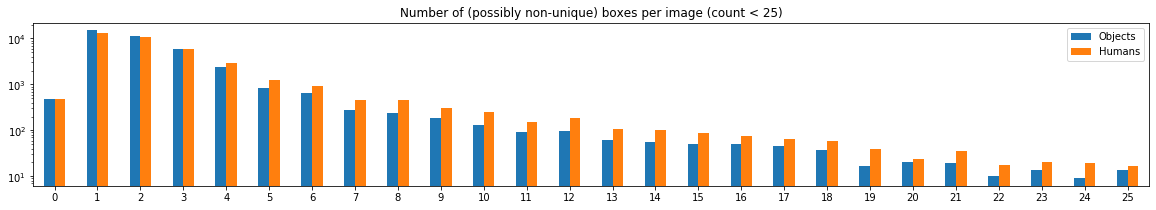

In [15]:
df.groupby('filename').agg({'bb_object': 'nunique', 'bb_human': 'nunique'}) \
  .rename(columns={'bb_object': 'Objects', 'bb_human': 'Humans'}) \
  .apply(pd.Series.value_counts) \
  .reindex(np.arange(26), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of (possibly non-unique) boxes per image (count < 25)');

Number of iteractions per image

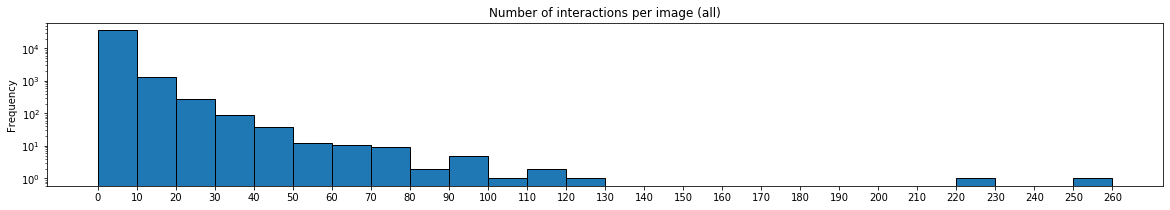

In [16]:
bins = np.arange(0, df.groupby('filename').size().max() + 10, 10)
ax = df.groupby('filename').size().plot.hist(logy=True, figsize=(20, 3), edgecolor='k', bins=bins, align='mid')
ax.set_title('Number of interactions per image (all)')
ax.set_xticks(bins);

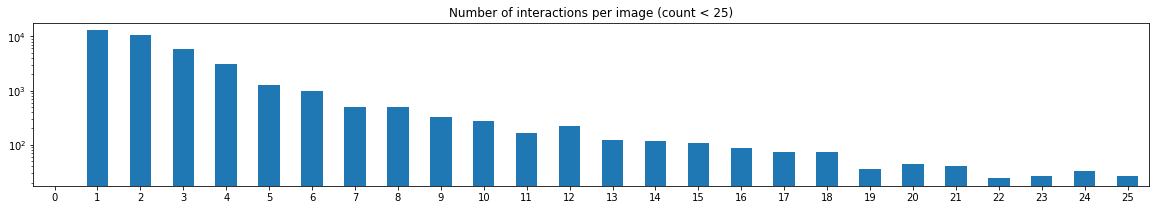

In [17]:
df.groupby('filename').size().value_counts().reindex(np.arange(26), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of interactions per image (count < 25)');

Most common object instances in the training set

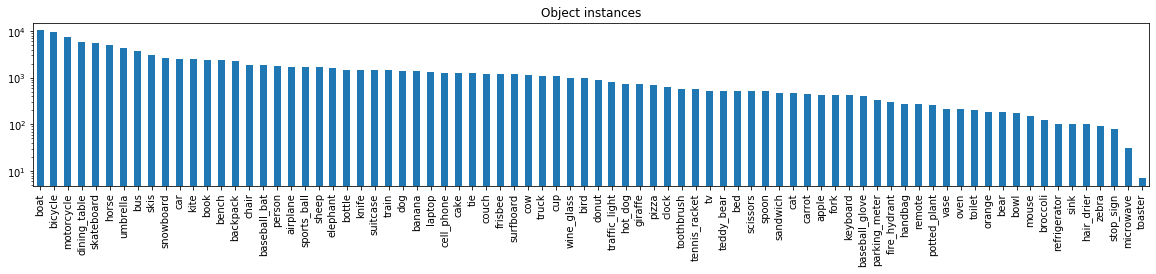

In [18]:
df.object.value_counts().plot.bar(logy=True, figsize=(20, 3)).set_title('Object instances');

Most common actions instances in the training set

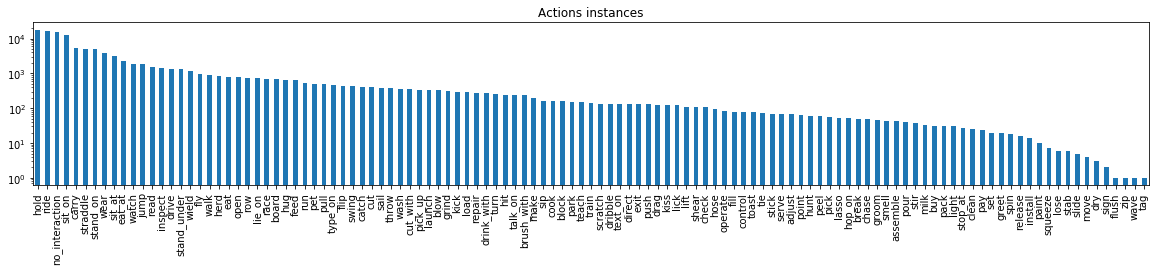

In [19]:
df.action.value_counts().plot.bar(logy=True, figsize=(20, 3)).set_title('Actions instances');

#### Object and action types

Number of unique object types per image

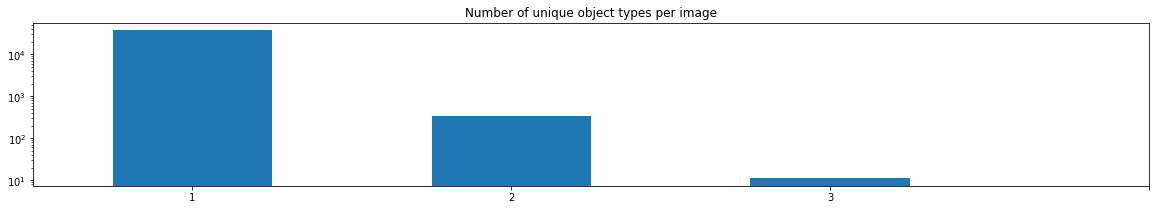

In [20]:
ax = df.groupby('filename').agg({'object': 'nunique'})['object'].value_counts().plot.bar(logy=True, figsize=(20, 3), rot=0)
ax.set_title('Number of unique object types per image');
ax.set_xticks(np.arange(df.groupby('filename').agg({'object': 'nunique'}).values.max() + 1));

Number of unique action types per image

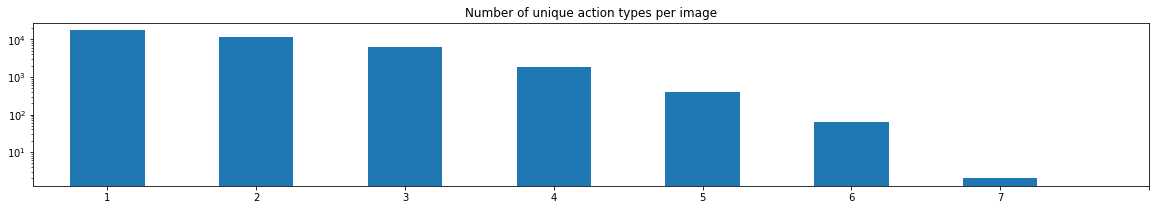

In [21]:
ax = df.groupby('filename').agg({'action': 'nunique'}).action.value_counts().plot.bar(logy=True, figsize=(20, 3), rot=0)
ax.set_title('Number of unique action types per image');
ax.set_xticks(np.arange(df.groupby('filename').agg({'action': 'nunique'}).values.max() + 1));

Most common interaction types

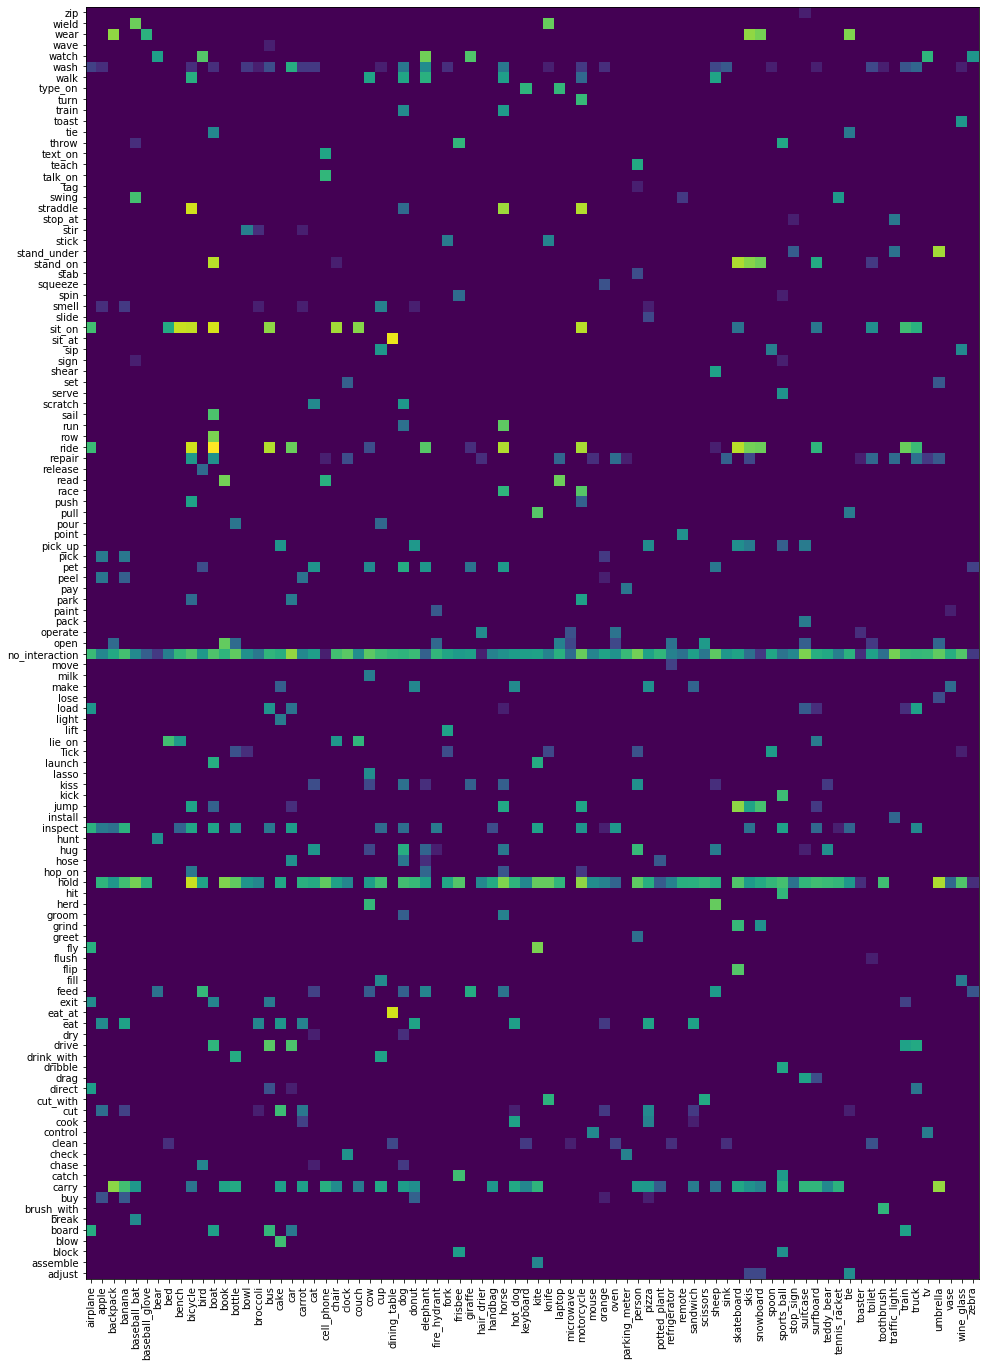

In [22]:
df_freq = df.groupby(['action', 'object']) \
    .interaction_id \
    .count() \
    .unstack('object', fill_value=0)

fig, ax = plt.subplots(1, 1, figsize=(df_freq.shape[1] / 5, df_freq.shape[0] / 5))
ax.pcolormesh(np.arange(df_freq.shape[1] + 1), np.arange(df_freq.shape[0] + 1), np.log(df_freq.values+1))
ax.set_xticks(np.arange(df_freq.shape[1] + 1) + .5)
ax.set_xticklabels(df_freq.columns, rotation=90);
ax.set_yticks(np.arange(df_freq.shape[0] + 1) + .5)
ax.set_yticklabels(df_freq.index, rotation=0)
ax.set_xlim(xmax=ax.get_xlim()[1] - .5)
ax.set_ylim(ymax=ax.get_ylim()[1] - .5);

## Problems

Some problems with the images / annotations

In [23]:
def show_all(filename, openwith='PIL'):
    if openwith == 'cv2':
        # cv2.imread applies EXIF rotations automatically,
        # but the annotations in the matlab file are made
        # for the non-rotated images
        img = cv2.cvtColor(
            cv2.imread((hico_dir / 'images' / 'train2015' / filename).as_posix()), 
            cv2.COLOR_BGR2RGB
        )
    else:
        img = Image.open(hico_dir / 'images' / 'train2015' / filename)
        img = np.asarray(img.convert('RGB'))
    
    df_img = df.query(f'filename == "{filename}"') \
               .drop(columns='filename') \
               .sort_values(['interaction_id', 'instance_id'])
    
    display(Markdown(f'{openwith} image: {filename}'))
    display(df_img.set_index(['interaction_id', 'instance_id']))
    
    if len(df_img) > 15:
        display(Markdown(f'Displaying only 8 relationships out of {len(df_img)}'))
        rg = np.random.default_rng(0)
        idx = rg.choice(len(df_img), replace=False, size=8)
        df_img = df_img.iloc[idx].sort_values(['interaction_id', 'instance_id'])
            
    ncols = min(1 + len(df_img), 3)
    nrows = int(np.ceil(len(df_img) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 8 * nrows), squeeze=False)
    
    ax = axes.flat[0]
    ax.imshow(img)
    ax.set_title(f'{filename} W={img.shape[1]} H={img.shape[0]}')
    
    for interaction, ax in zip(df_img.itertuples(), axes.flat[1:]):
        ax.imshow(img)
        ax.set_title(f'{interaction.action} {interaction.object} #{interaction.instance_id}')
        if not interaction.visible:
            continue
        ax.add_artist(plt.Rectangle(
            [interaction.bb_human[0], interaction.bb_human[1]],
            width=interaction.bb_human[2] - interaction.bb_human[0], 
            height=interaction.bb_human[3] - interaction.bb_human[1],
            fill=False,
            linewidth=5,
            color='blue'
        ))
        ax.add_artist(plt.Rectangle(
            [interaction.bb_object[0], interaction.bb_object[1]],
            width=interaction.bb_object[2] - interaction.bb_object[0], 
            height=interaction.bb_object[3] - interaction.bb_object[1],
            fill=False,
            linewidth=5,
            color='red'
        ))
    
    for ax in axes.flat:
        ax.set_axis_off()
    
    # Prevent embedding these images in the notebook
    save_path = Path(filename).with_suffix(f'.gt_relations.{openwith}.jpg')
    buff = io.BytesIO()
    fig.savefig(buff, format='png', facecolor='white', bbox_inches='tight')
    Image.open(buff).convert('RGB').save(save_path, 'JPEG')
    buff.close()
    plt.close(fig)
    display(Markdown(f'![{filename}]({save_path})'))

### EXIF orientation

If the image has an EXIF orientation tag, `cv2` loads the already rotated image, while `PIL` loads the image without applying rotations.

However, the annotations in the matlab file are made w.r.t. the non-rotated image.

In [24]:
exif_rotated_imgs = [
    'HICO_train2015_00028302.jpg',
    'HICO_train2015_00018679.jpg',
    'HICO_train2015_00019135.jpg',
    'HICO_train2015_00032020.jpg',
#     'HICO_test2015_00003183.jpg',
#     'HICO_test2015_00007684.jpg',
#     'HICO_test2015_00008817.jpg',
#     'HICO_test2015_00008435.jpg',
]

for filename in exif_rotated_imgs:
    show_all(filename, openwith='cv2')
    show_all(filename, openwith='PIL')

cv2 image: HICO_train2015_00028302.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
589,0,"(123, 104, 294, 636)","(244, 243, 282, 323)",True,hold,wine_glass


![HICO_train2015_00028302.jpg](HICO_train2015_00028302.gt_relations.cv2.jpg)

PIL image: HICO_train2015_00028302.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
589,0,"(123, 104, 294, 636)","(244, 243, 282, 323)",True,hold,wine_glass


![HICO_train2015_00028302.jpg](HICO_train2015_00028302.gt_relations.PIL.jpg)

cv2 image: HICO_train2015_00018679.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
215,0,"(61, 94, 266, 441)","(21, 226, 270, 422)",True,carry,banana


![HICO_train2015_00018679.jpg](HICO_train2015_00018679.gt_relations.cv2.jpg)

PIL image: HICO_train2015_00018679.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
215,0,"(61, 94, 266, 441)","(21, 226, 270, 422)",True,carry,banana


![HICO_train2015_00018679.jpg](HICO_train2015_00018679.gt_relations.PIL.jpg)

cv2 image: HICO_train2015_00019135.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
266,0,"(30, 80, 252, 498)","(250, 317, 363, 513)",True,cut,cake


![HICO_train2015_00019135.jpg](HICO_train2015_00019135.gt_relations.cv2.jpg)

PIL image: HICO_train2015_00019135.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
266,0,"(30, 80, 252, 498)","(250, 317, 363, 513)",True,cut,cake


![HICO_train2015_00019135.jpg](HICO_train2015_00019135.gt_relations.PIL.jpg)

cv2 image: HICO_train2015_00032020.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
283,0,"(39, 11, 242, 619)","(117, 70, 139, 89)",True,carry,cell_phone
284,0,"(42, 14, 240, 613)","(113, 66, 134, 99)",True,hold,cell_phone


![HICO_train2015_00032020.jpg](HICO_train2015_00032020.gt_relations.cv2.jpg)

PIL image: HICO_train2015_00032020.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
283,0,"(39, 11, 242, 619)","(117, 70, 139, 89)",True,carry,cell_phone
284,0,"(42, 14, 240, 613)","(113, 66, 134, 99)",True,hold,cell_phone


![HICO_train2015_00032020.jpg](HICO_train2015_00032020.gt_relations.PIL.jpg)

### Duplicate boxes

Multiple instances of the same interaction (action-object) reuse the bounding boxes.

In [25]:
show_all('HICO_train2015_00000009.jpg')

PIL image: HICO_train2015_00000009.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
570            0            (191, 102, 291, 306)  (211, 100, 432, 336)   
               1             (340, 94, 598, 407)  (211, 100, 432, 336)   

                            visible action object  
interaction_id instance_id                         
570            0               True   load  truck  
               1               True   load  truck

![HICO_train2015_00000009.jpg](HICO_train2015_00000009.gt_relations.PIL.jpg)

However, same objects but different actions result in different bounding boxes

In [26]:
show_all('HICO_train2015_00000001.jpg')

PIL image: HICO_train2015_00000001.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
152,0,"(208, 33, 427, 300)","(59, 98, 572, 405)",True,race,motorcycle
153,0,"(213, 20, 438, 357)","(77, 115, 583, 396)",True,ride,motorcycle
154,0,"(206, 33, 427, 306)","(61, 100, 571, 401)",True,sit_on,motorcycle
155,0,"(209, 26, 444, 317)","(59, 99, 579, 395)",True,straddle,motorcycle


![HICO_train2015_00000001.jpg](HICO_train2015_00000001.gt_relations.PIL.jpg)

No interaction instances

In [27]:
show_all('HICO_train2015_00000002.jpg')

PIL image: HICO_train2015_00000002.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
223,0,"(262, 1, 638, 138)","(162, 131, 258, 165)",True,no_interaction,banana


![HICO_train2015_00000002.jpg](HICO_train2015_00000002.gt_relations.PIL.jpg)

In [28]:
show_all('HICO_train2015_00000003.jpg')

PIL image: HICO_train2015_00000003.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
64,0,"(567, 361, 580, 390)","(74, 52, 510, 484)",True,no_interaction,bus


![HICO_train2015_00000003.jpg](HICO_train2015_00000003.gt_relations.PIL.jpg)

Debatable human boxes

In [29]:
show_all('HICO_train2015_00000013.jpg')

PIL image: HICO_train2015_00000013.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
275,0,"(198, 287, 278, 395)","(88, 206, 248, 310)",True,cut,carrot


![HICO_train2015_00000013.jpg](HICO_train2015_00000013.gt_relations.PIL.jpg)

Debatable object boxes

In [30]:
show_all('HICO_train2015_00000025.jpg')

PIL image: HICO_train2015_00000025.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
432,0,"(273, 11, 446, 392)","(1, 1, 638, 428)",True,open,refrigerator


![HICO_train2015_00000025.jpg](HICO_train2015_00000025.gt_relations.PIL.jpg)

Invisible interactions

In [31]:
show_all('HICO_train2015_00000014.jpg')

PIL image: HICO_train2015_00000014.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
5,-1,None,None,False,load,airplane


![HICO_train2015_00000014.jpg](HICO_train2015_00000014.gt_relations.PIL.jpg)

Crowds

In [32]:
show_all('HICO_train2015_00000086.jpg')

PIL image: HICO_train2015_00000086.jpg

bb_human         bb_object  visible  \
interaction_id instance_id                                                    
38             0            (427, 279, 433, 300)  (3, 5, 639, 421)     True   
               1            (259, 254, 267, 276)  (3, 5, 639, 421)     True   
               2            (202, 278, 207, 307)  (3, 5, 639, 421)     True   
               3            (249, 256, 259, 275)  (3, 5, 639, 421)     True   
               4            (231, 259, 246, 273)  (3, 5, 639, 421)     True   
...                                          ...               ...      ...   
42             35            (85, 278, 108, 377)  (1, 3, 637, 422)     True   
               36           (485, 275, 512, 360)  (1, 3, 637, 422)     True   
               37           (563, 273, 592, 384)  (1, 3, 637, 422)     True   
               38           (579, 276, 620, 377)  (1, 3, 637, 422)     True   
               39             (42, 267, 74, 419)  (1, 3, 637, 422)     True   

                              action object  
interaction_id instance_id                   
38             0                ride   boat  
               1                ride   boat  
               2                ride   boat  
               3                ride   boat  
               4                ride   boat  
...                              ...    ...  
42             35           stand_on   boat  
               36           stand_on   boat  
               37           stand_on   boat  
               38           stand_on   boat  
               39           stand_on   boat  

[78 rows x 5 columns]

Displaying only 8 relationships out of 78

![HICO_train2015_00000086.jpg](HICO_train2015_00000086.gt_relations.PIL.jpg)

Too many objects

In [33]:
show_all('HICO_train2015_00005052.jpg')

PIL image: HICO_train2015_00005052.jpg

bb_human             bb_object  \
interaction_id instance_id                                              
219            0            (78, 269, 304, 638)  (100, 559, 112, 576)   
               1            (78, 269, 304, 638)  (138, 518, 146, 543)   
               2            (78, 269, 304, 638)  (110, 557, 126, 570)   
               3            (78, 269, 304, 638)  (163, 426, 188, 436)   
               4            (78, 269, 304, 638)   (94, 542, 117, 554)   
...                                         ...                   ...   
               101          (78, 269, 304, 638)  (121, 250, 154, 298)   
               102          (78, 269, 304, 638)   (97, 592, 143, 628)   
               103          (78, 269, 304, 638)  (148, 306, 194, 346)   
               104          (78, 269, 304, 638)  (138, 282, 172, 337)   
               105          (78, 269, 304, 638)  (249, 228, 303, 282)   

                            visible   action  object  
interaction_id instance_id                            
219            0               True  inspect  banana  
               1               True  inspect  banana  
               2               True  inspect  banana  
               3               True  inspect  banana  
               4               True  inspect  banana  
...                             ...      ...     ...  
               101             True  inspect  banana  
               102             True  inspect  banana  
               103             True  inspect  banana  
               104             True  inspect  banana  
               105             True  inspect  banana  

[106 rows x 5 columns]

Displaying only 8 relationships out of 106

![HICO_train2015_00005052.jpg](HICO_train2015_00005052.gt_relations.PIL.jpg)

Too many _no interaction_ annotations

In [34]:
show_all('HICO_train2015_00029944.jpg')

PIL image: HICO_train2015_00029944.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
515            0            (194, 322, 210, 347)  (218, 397, 246, 415)   
               1            (194, 322, 210, 347)  (285, 364, 317, 393)   
               2            (194, 322, 210, 347)  (376, 362, 417, 390)   
               3            (194, 322, 210, 347)     (3, 411, 41, 442)   
               4            (194, 322, 210, 347)  (246, 387, 295, 414)   
...                                          ...                   ...   
               250           (94, 254, 138, 394)  (121, 418, 233, 462)   
               251           (94, 254, 138, 394)    (11, 474, 90, 570)   
               252           (94, 254, 138, 394)  (134, 494, 257, 570)   
               253           (94, 254, 138, 394)  (190, 498, 313, 574)   
               254           (94, 254, 138, 394)   (51, 466, 188, 563)   

                            visible          action    object  
interaction_id instance_id                                     
515            0               True  no_interaction  suitcase  
               1               True  no_interaction  suitcase  
               2               True  no_interaction  suitcase  
               3               True  no_interaction  suitcase  
               4               True  no_interaction  suitcase  
...                             ...             ...       ...  
               250             True  no_interaction  suitcase  
               251             True  no_interaction  suitcase  
               252             True  no_interaction  suitcase  
               253             True  no_interaction  suitcase  
               254             True  no_interaction  suitcase  

[255 rows x 5 columns]

Displaying only 8 relationships out of 255

![HICO_train2015_00029944.jpg](HICO_train2015_00029944.gt_relations.PIL.jpg)

### Merging duplicates

We use non-maximum suppression to detect duplicate boxes and merge them.

NMS usually would compare pairwise IoU and box scores, but in this case we consider all scores to be 1.

When applying NMS, use the class id to avoid merging boxes of different classes.

In [35]:
show_all('HICO_train2015_00032912.jpg')

PIL image: HICO_train2015_00032912.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
109            0            (194, 266, 291, 386)  (214, 376, 438, 473)   
               1            (382, 244, 502, 555)  (214, 376, 438, 473)   
               2            (307, 271, 430, 586)  (214, 376, 438, 473)   
               3            (125, 258, 331, 593)  (214, 376, 438, 473)   
173            0            (453, 203, 503, 287)  (491, 147, 634, 570)   
               1            (453, 203, 503, 287)    (4, 168, 149, 614)   
               2            (337, 182, 414, 262)  (491, 147, 634, 570)   
               3            (337, 182, 414, 262)    (4, 168, 149, 614)   
               4            (194, 254, 286, 398)  (491, 147, 634, 570)   
               5            (194, 254, 286, 398)    (4, 168, 149, 614)   
               6            (376, 238, 493, 558)  (491, 147, 634, 570)   
               7            (376, 238, 493, 558)    (4, 168, 149, 614)   
               8            (301, 261, 425, 578)  (491, 147, 634, 570)   
               9            (301, 261, 425, 578)    (4, 168, 149, 614)   
               10           (129, 257, 332, 600)  (491, 147, 634, 570)   
               11           (129, 257, 332, 600)    (4, 168, 149, 614)   
594            0            (458, 198, 508, 288)  (261, 345, 289, 403)   
               1            (458, 198, 508, 288)  (281, 322, 310, 382)   
               2            (342, 187, 411, 272)  (261, 345, 289, 403)   
               3            (342, 187, 411, 272)  (281, 322, 310, 382)   
               4            (191, 254, 286, 387)  (261, 345, 289, 403)   
               5            (379, 235, 501, 559)  (261, 345, 289, 403)   
               6            (379, 235, 501, 559)  (281, 322, 310, 382)   
               7            (298, 263, 428, 588)  (261, 345, 289, 403)   
               8            (298, 263, 428, 588)  (281, 322, 310, 382)   
               9            (126, 260, 332, 590)  (261, 345, 289, 403)   
               10           (126, 260, 332, 590)  (281, 322, 310, 382)   

                            visible          action        object  
interaction_id instance_id                                         
109            0               True          sit_at  dining_table  
               1               True          sit_at  dining_table  
               2               True          sit_at  dining_table  
               3               True          sit_at  dining_table  
173            0               True  no_interaction  potted_plant  
               1               True  no_interaction  potted_plant  
               2               True  no_interaction  potted_plant  
               3               True  no_interaction  potted_plant  
               4               True  no_interaction  potted_plant  
               5               True  no_interaction  potted_plant  
               6               True  no_interaction  potted_plant  
               7               True  no_interaction  potted_plant  
               8               True  no_interaction  potted_plant  
               9               True  no_interaction  potted_plant  
               10              True  no_interaction  potted_plant  
               11              True  no_interaction  potted_plant  
594            0               True  no_interaction    wine_glass  
               1               True  no_interaction    wine_glass  
               2               True  no_interaction    wine_glass  
               3               True  no_interaction    wine_glass  
               4               True  no_interaction    wine_glass  
               5               True  no_interaction    wine_glass  
               6               True  no_interaction    wine_glass  
               7               True  no_interaction    wine_glass  
               8               True  no_interaction    wine_glass  
               9               True  no_interaction    wi

Displaying only 8 relationships out of 27

![HICO_train2015_00032912.jpg](HICO_train2015_00032912.gt_relations.PIL.jpg)

In [36]:
df_img = df.query('filename == "HICO_train2015_00032912.jpg"') \
  .drop(columns=['filename', 'visible']) \
  .set_index(['interaction_id', 'instance_id']) \
  .sort_index()
df_img

bb_human             bb_object  \
interaction_id instance_id                                               
109            0            (194, 266, 291, 386)  (214, 376, 438, 473)   
               1            (382, 244, 502, 555)  (214, 376, 438, 473)   
               2            (307, 271, 430, 586)  (214, 376, 438, 473)   
               3            (125, 258, 331, 593)  (214, 376, 438, 473)   
173            0            (453, 203, 503, 287)  (491, 147, 634, 570)   
               1            (453, 203, 503, 287)    (4, 168, 149, 614)   
               2            (337, 182, 414, 262)  (491, 147, 634, 570)   
               3            (337, 182, 414, 262)    (4, 168, 149, 614)   
               4            (194, 254, 286, 398)  (491, 147, 634, 570)   
               5            (194, 254, 286, 398)    (4, 168, 149, 614)   
               6            (376, 238, 493, 558)  (491, 147, 634, 570)   
               7            (376, 238, 493, 558)    (4, 168, 149, 614)   
               8            (301, 261, 425, 578)  (491, 147, 634, 570)   
               9            (301, 261, 425, 578)    (4, 168, 149, 614)   
               10           (129, 257, 332, 600)  (491, 147, 634, 570)   
               11           (129, 257, 332, 600)    (4, 168, 149, 614)   
594            0            (458, 198, 508, 288)  (261, 345, 289, 403)   
               1            (458, 198, 508, 288)  (281, 322, 310, 382)   
               2            (342, 187, 411, 272)  (261, 345, 289, 403)   
               3            (342, 187, 411, 272)  (281, 322, 310, 382)   
               4            (191, 254, 286, 387)  (261, 345, 289, 403)   
               5            (379, 235, 501, 559)  (261, 345, 289, 403)   
               6            (379, 235, 501, 559)  (281, 322, 310, 382)   
               7            (298, 263, 428, 588)  (261, 345, 289, 403)   
               8            (298, 263, 428, 588)  (281, 322, 310, 382)   
               9            (126, 260, 332, 590)  (261, 345, 289, 403)   
               10           (126, 260, 332, 590)  (281, 322, 310, 382)   

                                    action        object  
interaction_id instance_id                                
109            0                    sit_at  dining_table  
               1                    sit_at  dining_table  
               2                    sit_at  dining_table  
               3                    sit_at  dining_table  
173            0            no_interaction  potted_plant  
               1            no_interaction  potted_plant  
               2            no_interaction  potted_plant  
               3            no_interaction  potted_plant  
               4            no_interaction  potted_plant  
               5            no_interaction  potted_plant  
               6            no_interaction  potted_plant  
               7            no_interaction  potted_plant  
               8            no_interaction  potted_plant  
               9            no_interaction  potted_plant  
               10           no_interaction  potted_plant  
               11           no_interaction  potted_plant  
594            0            no_interaction    wine_glass  
               1            no_interaction    wine_glass  
               2            no_interaction    wine_glass  
               3            no_interaction    wine_glass  
               4            no_interaction    wine_glass  
               5            no_interaction    wine_glass  
               6            no_interaction    wine_glass  
               7            no_interaction    wine_glass  
               8            no_interaction    wine_glass  
               9            no_interaction    wine_glass  
               10           no_interaction    wine_glass

In [37]:
boxes = df_img.bb_human.tolist() + df_img.bb_object.tolist()
classes = np.array(['human'] * len(df_img.bb_human) + df_img.object.tolist())

relation_indexes = torch.stack([
    torch.arange(0, len(df_img)),
    torch.arange(len(df_img), len(df_img) * 2)
], dim=0)

with pd.option_context('display.max_rows', 10):    
    display(pd.DataFrame({
        'boxes': boxes,
        'classes': classes,
    }).rename_axis(index='box_id'))
    display(pd.DataFrame(
        relation_indexes.numpy().transpose(), 
        index=df_img.index, 
        columns=['subj_box_id', 'obj_box_id']
    ))

boxes = torch.tensor(boxes, dtype=torch.float)

,boxes,classes
box_id,,
0,"(194, 266, 291, 386)",human
1,"(382, 244, 502, 555)",human
2,"(307, 271, 430, 586)",human
3,"(125, 258, 331, 593)",human
4,"(453, 203, 503, 287)",human
...,...,...
49,"(281, 322, 310, 382)",wine_glass
50,"(261, 345, 289, 403)",wine_glass
51,"(281, 322, 310, 382)",wine_glass


subj_box_id  obj_box_id
interaction_id instance_id                         
109            0                      0          27
               1                      1          28
               2                      2          29
               3                      3          30
173            0                      4          31
...                                 ...         ...
594            6                     22          49
               7                     23          50
               8                     24          51
               9                     25          52
               10                    26          53

[27 rows x 2 columns]

This is the pairwise IoU of all boxes in the image.

In [38]:
iou = box_iou(boxes, boxes)
iou[classes[:, None] != classes[None, :]] = np.nan

index = pd.MultiIndex.from_arrays((
    classes,
    np.arange(len(boxes))
), names=['classes', 'box_id'])

display(pd.DataFrame(100 * iou.numpy(), index=index, columns=index)
    .sort_index('index', level=0)
    .sort_index('columns', level=0)
    .style
    .format('{:.0f}', na_rep='')
    .background_gradient(axis=None, vmin=0, vmax=100)
    .set_properties(**{'font-size': 'smaller'})
    .set_table_styles([{'selector': 'th', 'props': [('font-size', 'smaller')]}])
)

/home/federico/anaconda3/envs/eccv/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


These are the boxes that NMS would keep:

In [39]:
keep = batched_nms(
    boxes, 
    scores=torch.ones(len(boxes)), 
    idxs=torch.from_numpy(pd.Series(classes).apply({c: i for i, c in enumerate(np.unique(classes))}.get).values), 
    iou_threshold=.7
)
keep_iou = iou[:, keep][keep, :]

display(pd.DataFrame(100 * keep_iou.numpy(), index=index[keep], columns=index[keep])
    .sort_index('index', level=0)
    .sort_index('columns', level=0)
    .style
    .format('{:.0f}', na_rep='')
    .background_gradient(axis=None, vmin=0, vmax=100)
    .set_properties(**{'font-size': 'smaller'})
    .set_table_styles([{'selector': 'th', 'props': [('font-size', 'smaller')]}])
)

However, knowing which boxes to keep is not enough to fix the relationship indexes.
We also need to know which boxes were aggregated with which other boxes.

In [40]:
iou_above_thres = box_iou(boxes, boxes) > .7
iou_above_thres[classes[:, None] != classes[None, :]] = False

keep = []
groups = []
visited = torch.full((len(boxes),), False, dtype=torch.bool)
for i, skip in enumerate(visited):
    if skip:
        continue
    keep.append(i)
    
    matches = torch.nonzero(iou_above_thres[i, :] & ~visited, as_tuple=True)[0]
    visited[matches] = True
    groups.append(matches)

new_boxes = boxes[keep]
new_relation_indexes = relation_indexes.clone()
for new_box_id, g in enumerate(groups):
    mask = torch.any(new_relation_indexes[:,:,None] == g[None, None,:], dim=2)
    new_relation_indexes[mask] = new_box_id

with pd.option_context('display.max_rows', 11):    
    display(pd.DataFrame({
        'boxes': [tuple(b) for b in new_boxes.int().numpy()],
        'classes': classes[keep],
    }).rename_axis(index='new_box_id'))
    display(pd.DataFrame(
        new_relation_indexes.numpy().transpose(), 
        index=df_img.index, 
        columns=['subj_new_box_id', 'obj_new_box_id']
    ))

,boxes,classes
new_box_id,,
0,"(194, 266, 291, 386)",human
1,"(382, 244, 502, 555)",human
2,"(307, 271, 430, 586)",human
3,"(125, 258, 331, 593)",human
4,"(453, 203, 503, 287)",human
5,"(337, 182, 414, 262)",human
6,"(214, 376, 438, 473)",dining_table
7,"(491, 147, 634, 570)",potted_plant
8,"(4, 168, 149, 614)",potted_plant


subj_new_box_id  obj_new_box_id
interaction_id instance_id                                 
109            0                          0               6
               1                          1               6
               2                          2               6
               3                          3               6
173            0                          4               7
...                                     ...             ...
594            6                          1              10
               7                          2               9
               8                          2              10
               9                          3               9
               10                         3              10

[27 rows x 2 columns]

## More images

Smallest image by area

In [41]:
show_all(img_info.iloc[(img_info.H * img_info.W).idxmin()].filename)

PIL image: HICO_train2015_00002389.jpg

bb_human         bb_object  visible  \
interaction_id instance_id                                                 
366            0              (3, 33, 46, 81)   (11, 7, 34, 58)     True   
               1            (40, 46, 119, 88)  (43, 1, 120, 87)     True   

                             action    object  
interaction_id instance_id                     
366            0            type_on  keyboard  
               1            type_on  keyboard

![HICO_train2015_00002389.jpg](HICO_train2015_00002389.gt_relations.PIL.jpg)

Most vertically elongated image

In [42]:
show_all(img_info.iloc[(img_info.H / img_info.W).idxmax()].filename)

PIL image: HICO_train2015_00011514.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
377,0,"(16, 276, 197, 634)","(20, 10, 168, 333)",True,hold,knife
380,0,"(3, 281, 210, 638)","(33, 3, 125, 318)",True,wield,knife


![HICO_train2015_00011514.jpg](HICO_train2015_00011514.gt_relations.PIL.jpg)

Most horizontally elongated image

In [43]:
show_all(img_info.iloc[(img_info.H / img_info.W).idxmin()].filename)

PIL image: HICO_train2015_00002727.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
329,0,"(617, 55, 640, 101)","(617, 94, 640, 133)",True,no_interaction,fire_hydrant


![HICO_train2015_00002727.jpg](HICO_train2015_00002727.gt_relations.PIL.jpg)

Images with most variety of object types:

In [44]:
for filename in df.groupby(['filename', 'object']).size().reset_index('object').groupby('filename').size().sort_values().tail(5).index:
    show_all(filename)

PIL image: HICO_train2015_00026655.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
89,0,"(83, 6, 597, 445)","(105, 62, 519, 328)",True,sit_on,chair
297,0,"(82, 3, 597, 449)","(367, 219, 521, 343)",True,hold,cup
544,0,"(86, 74, 595, 408)","(270, 196, 319, 237)",True,wear,tie


![HICO_train2015_00026655.jpg](HICO_train2015_00026655.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00032912.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
109            0            (194, 266, 291, 386)  (214, 376, 438, 473)   
               1            (382, 244, 502, 555)  (214, 376, 438, 473)   
               2            (307, 271, 430, 586)  (214, 376, 438, 473)   
               3            (125, 258, 331, 593)  (214, 376, 438, 473)   
173            0            (453, 203, 503, 287)  (491, 147, 634, 570)   
               1            (453, 203, 503, 287)    (4, 168, 149, 614)   
               2            (337, 182, 414, 262)  (491, 147, 634, 570)   
               3            (337, 182, 414, 262)    (4, 168, 149, 614)   
               4            (194, 254, 286, 398)  (491, 147, 634, 570)   
               5            (194, 254, 286, 398)    (4, 168, 149, 614)   
               6            (376, 238, 493, 558)  (491, 147, 634, 570)   
               7            (376, 238, 493, 558)    (4, 168, 149, 614)   
               8            (301, 261, 425, 578)  (491, 147, 634, 570)   
               9            (301, 261, 425, 578)    (4, 168, 149, 614)   
               10           (129, 257, 332, 600)  (491, 147, 634, 570)   
               11           (129, 257, 332, 600)    (4, 168, 149, 614)   
594            0            (458, 198, 508, 288)  (261, 345, 289, 403)   
               1            (458, 198, 508, 288)  (281, 322, 310, 382)   
               2            (342, 187, 411, 272)  (261, 345, 289, 403)   
               3            (342, 187, 411, 272)  (281, 322, 310, 382)   
               4            (191, 254, 286, 387)  (261, 345, 289, 403)   
               5            (379, 235, 501, 559)  (261, 345, 289, 403)   
               6            (379, 235, 501, 559)  (281, 322, 310, 382)   
               7            (298, 263, 428, 588)  (261, 345, 289, 403)   
               8            (298, 263, 428, 588)  (281, 322, 310, 382)   
               9            (126, 260, 332, 590)  (261, 345, 289, 403)   
               10           (126, 260, 332, 590)  (281, 322, 310, 382)   

                            visible          action        object  
interaction_id instance_id                                         
109            0               True          sit_at  dining_table  
               1               True          sit_at  dining_table  
               2               True          sit_at  dining_table  
               3               True          sit_at  dining_table  
173            0               True  no_interaction  potted_plant  
               1               True  no_interaction  potted_plant  
               2               True  no_interaction  potted_plant  
               3               True  no_interaction  potted_plant  
               4               True  no_interaction  potted_plant  
               5               True  no_interaction  potted_plant  
               6               True  no_interaction  potted_plant  
               7               True  no_interaction  potted_plant  
               8               True  no_interaction  potted_plant  
               9               True  no_interaction  potted_plant  
               10              True  no_interaction  potted_plant  
               11              True  no_interaction  potted_plant  
594            0               True  no_interaction    wine_glass  
               1               True  no_interaction    wine_glass  
               2               True  no_interaction    wine_glass  
               3               True  no_interaction    wine_glass  
               4               True  no_interaction    wine_glass  
               5               True  no_interaction    wine_glass  
               6               True  no_interaction    wine_glass  
               7               True  no_interaction    wine_glass  
               8               True  no_interaction    wine_glass  
               9               True  no_interaction    wi

Displaying only 8 relationships out of 27

![HICO_train2015_00032912.jpg](HICO_train2015_00032912.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00021319.jpg

bb_human             bb_object  visible  \
interaction_id instance_id                                                     
366            0             (6, 2, 512, 415)   (364, 77, 546, 228)     True   
383            0             (3, 1, 635, 425)  (249, 159, 373, 274)     True   
396            0            (135, 2, 362, 60)  (337, 232, 398, 337)     True   
               1             (2, 1, 638, 424)  (337, 232, 398, 337)     True   

                                    action    object  
interaction_id instance_id                            
366            0                   type_on  keyboard  
383            0                      hold    laptop  
396            0            no_interaction     mouse  
               1            no_interaction     mouse

![HICO_train2015_00021319.jpg](HICO_train2015_00021319.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000528.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
89,0,"(182, 4, 621, 446)","(510, 154, 566, 254)",True,sit_on,chair
223,0,"(170, 5, 632, 462)","(1, 221, 420, 478)",True,no_interaction,banana
385,0,"(174, 2, 629, 460)","(2, 234, 422, 478)",True,read,laptop
387,0,"(214, 2, 606, 457)","(3, 236, 416, 478)",True,type_on,laptop


![HICO_train2015_00000528.jpg](HICO_train2015_00000528.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000547.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
53,0,"(4, 36, 266, 532)","(327, 113, 362, 196)",True,no_interaction,bottle
452,0,"(1, 37, 262, 538)","(125, 94, 360, 213)",True,no_interaction,sink
483,0,"(4, 33, 266, 534)","(218, 236, 329, 312)",True,hold,spoon


![HICO_train2015_00000547.jpg](HICO_train2015_00000547.gt_relations.PIL.jpg)

Images with most variety of action types:

In [45]:
for filename in df.groupby(['filename', 'action']).size().reset_index('action').groupby('filename').size().sort_values().tail(5).index:
    show_all(filename)

PIL image: HICO_train2015_00010315.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
131,0,"(264, 28, 528, 364)","(92, 162, 639, 490)",True,hold,horse
133,0,"(261, 30, 528, 370)","(87, 147, 638, 485)",True,jump,horse
139,0,"(258, 17, 528, 362)","(85, 158, 639, 489)",True,ride,horse
140,0,"(270, 28, 528, 369)","(86, 158, 635, 481)",True,run,horse
141,0,"(262, 27, 569, 291)","(59, 126, 602, 436)",True,straddle,horse
142,0,"(259, 22, 531, 366)","(87, 154, 638, 492)",True,train,horse


![HICO_train2015_00010315.jpg](HICO_train2015_00010315.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00034774.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
131,0,"(228, 16, 360, 219)","(127, 50, 484, 381)",True,hold,horse
133,0,"(231, 18, 358, 209)","(133, 56, 483, 357)",True,jump,horse
139,0,"(232, 14, 356, 214)","(133, 52, 482, 389)",True,ride,horse
140,0,"(226, 12, 359, 220)","(131, 48, 479, 380)",True,run,horse
141,0,"(230, 16, 354, 214)","(133, 59, 479, 358)",True,straddle,horse
142,0,"(231, 16, 363, 214)","(133, 56, 485, 366)",True,train,horse


![HICO_train2015_00034774.jpg](HICO_train2015_00034774.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00020416.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
146,0,"(114, 103, 297, 383)","(46, 209, 387, 450)",True,hold,motorcycle
148,0,"(123, 132, 283, 364)","(68, 218, 370, 441)",True,jump,motorcycle
152,0,"(90, 129, 258, 361)","(73, 221, 388, 444)",True,race,motorcycle
153,0,"(122, 131, 281, 364)","(74, 225, 370, 441)",True,ride,motorcycle
154,0,"(126, 134, 293, 358)","(74, 228, 372, 440)",True,sit_on,motorcycle
155,0,"(123, 129, 281, 366)","(67, 222, 377, 446)",True,straddle,motorcycle


![HICO_train2015_00020416.jpg](HICO_train2015_00020416.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00036176.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
31             0            (303, 226, 325, 263)     (1, 16, 636, 356)   
               1            (303, 279, 331, 314)     (1, 16, 636, 356)   
32             0            (267, 303, 293, 339)  (207, 282, 331, 373)   
36             0            (303, 279, 327, 317)  (212, 293, 331, 371)   
38             0            (320, 330, 325, 340)  (216, 298, 321, 363)   
               1            (286, 315, 295, 327)  (216, 298, 321, 363)   
               2            (303, 320, 311, 335)  (216, 298, 321, 363)   
               3            (247, 302, 255, 320)  (216, 298, 321, 363)   
               4            (262, 308, 271, 330)  (216, 298, 321, 363)   
               5            (271, 309, 282, 335)  (216, 298, 321, 363)   
               6            (299, 329, 314, 352)  (216, 298, 321, 363)   
41             0            (243, 303, 255, 325)  (214, 295, 338, 368)   
42             0            (282, 176, 292, 195)      (1, 1, 637, 367)   
               1            (284, 319, 292, 343)  (217, 301, 344, 363)   
               2            (309, 332, 322, 348)  (217, 301, 344, 363)   
               3            (262, 311, 271, 333)  (217, 301, 344, 363)   
               4            (272, 311, 281, 338)  (217, 301, 344, 363)   
               5            (286, 324, 299, 344)  (217, 301, 344, 363)   
               6            (294, 326, 308, 346)  (217, 301, 344, 363)   
               7              (10, 173, 25, 200)      (1, 1, 637, 367)   
43             0            (298, 225, 329, 265)      (5, 3, 637, 367)   

                            visible    action object  
interaction_id instance_id                            
31             0               True     board   boat  
               1               True     board   boat  
32             0               True     drive   boat  
36             0               True    launch   boat  
38             0               True      ride   boat  
               1               True      ride   boat  
               2               True      ride   boat  
               3               True      ride   boat  
               4               True      ride   boat  
               5               True      ride   boat  
               6               True      ride   boat  
41             0               True    sit_on   boat  
42             0               True  stand_on   boat  
               1               True  stand_on   boat  
               2               True  stand_on   boat  
               3               True  stand_on   boat  
               4               True  stand_on   boat  
               5               True  stand_on   boat  
               6               True  stand_on   boat  
               7               True  stand_on   boat  
43             0               True       tie   boat

Displaying only 8 relationships out of 21

![HICO_train2015_00036176.jpg](HICO_train2015_00036176.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00037793.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
463            0            (277, 240, 369, 353)  (330, 302, 366, 362)   
464            0            (256, 153, 320, 274)  (313, 123, 322, 236)   
               1            (276, 238, 371, 354)  (325, 262, 380, 377)   
               2            (130, 159, 202, 385)   (178, 71, 219, 303)   
465            0             (32, 167, 158, 477)    (1, 154, 164, 479)   
466            0            (276, 241, 371, 350)  (326, 302, 369, 365)   
468            0            (281, 238, 346, 343)  (325, 293, 351, 369)   
471            0            (274, 234, 366, 350)  (298, 299, 389, 351)   
472            0            (118, 170, 201, 387)   (176, 79, 217, 304)   

                            visible    action object  
interaction_id instance_id                            
463            0               True    adjust   skis  
464            0               True     carry   skis  
               1               True     carry   skis  
               2               True     carry   skis  
465            0               True      hold   skis  
466            0               True   inspect   skis  
468            0               True   pick_up   skis  
471            0               True  stand_on   skis  
472            0               True      wear   skis

![HICO_train2015_00037793.jpg](HICO_train2015_00037793.gt_relations.PIL.jpg)

In [46]:
for i in range(50, 60):
    show_all(f'HICO_train2015_000000{i}.jpg')

PIL image: HICO_train2015_00000050.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
329,0,"(158, 161, 245, 415)","(223, 299, 292, 416)",True,no_interaction,fire_hydrant


![HICO_train2015_00000050.jpg](HICO_train2015_00000050.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000051.jpg

bb_human             bb_object  \
interaction_id instance_id                                               
225            0            (364, 142, 379, 242)  (368, 235, 393, 391)   
               1             (294, 42, 380, 107)  (368, 235, 393, 391)   
226            0             (281, 39, 384, 411)  (359, 217, 399, 396)   

                            visible action        object  
interaction_id instance_id                                
225            0               True  carry  baseball_bat  
               1               True  carry  baseball_bat  
226            0               True   hold  baseball_bat

![HICO_train2015_00000051.jpg](HICO_train2015_00000051.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000052.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
226,0,"(2, 50, 264, 427)","(197, 66, 400, 293)",True,hold,baseball_bat
230,0,"(5, 34, 262, 423)","(212, 70, 422, 293)",True,wield,baseball_bat


![HICO_train2015_00000052.jpg](HICO_train2015_00000052.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000053.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
89,-1,None,None,False,sit_on,chair


![HICO_train2015_00000053.jpg](HICO_train2015_00000053.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000054.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
462,0,"(18, 18, 417, 639)","(317, 227, 478, 306)",True,no_interaction,skateboard


![HICO_train2015_00000054.jpg](HICO_train2015_00000054.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000055.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
370,0,"(490, 214, 563, 386)","(90, 94, 141, 146)",True,fly,kite
374,0,"(498, 224, 557, 381)","(552, 90, 637, 225)",True,pull,kite


![HICO_train2015_00000055.jpg](HICO_train2015_00000055.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000056.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
9,0,"(14, 135, 317, 512)","(153, 16, 478, 138)",True,no_interaction,airplane


![HICO_train2015_00000056.jpg](HICO_train2015_00000056.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000057.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
75,0,"(594, 112, 630, 152)","(2, 62, 554, 421)",True,no_interaction,car


![HICO_train2015_00000057.jpg](HICO_train2015_00000057.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000058.jpg

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
226,0,"(102, 190, 372, 480)","(258, 138, 354, 314)",True,hold,baseball_bat
230,0,"(104, 193, 370, 479)","(277, 142, 352, 309)",True,wield,baseball_bat


![HICO_train2015_00000058.jpg](HICO_train2015_00000058.gt_relations.PIL.jpg)

PIL image: HICO_train2015_00000059.jpg

bb_human            bb_object  \
interaction_id instance_id                                              
154            0             (388, 56, 555, 426)  (51, 213, 637, 422)   
155            0             (148, 94, 292, 267)   (2, 128, 393, 413)   
               1            (395, 101, 557, 423)   (60, 89, 635, 425)   

                            visible    action      object  
interaction_id instance_id                                 
154            0               True    sit_on  motorcycle  
155            0               True  straddle  motorcycle  
               1               True  straddle  motorcycle

![HICO_train2015_00000059.jpg](HICO_train2015_00000059.gt_relations.PIL.jpg)